In [1]:
%cd ..

/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code


In [29]:
import geopandas as gpd
from atl_module.geospatial_utils.raster_interaction import query_from_lines
import matplotlib.pyplot as plt
import numpy as np


In [36]:
transect_number = 7


In [37]:
tracklines = gpd.read_file("../data/test_sites/florida_keys/tracklines/")
trackline_test = tracklines.geometry[transect_number]
kriging_points = gpd.read_file("../data/test_sites/florida_keys/kriging_pts/")
utm_line = tracklines.to_crs(kriging_points.crs).geometry[transect_number]
clipped_kriging_points = kriging_points.clip(utm_line.buffer(50)).to_crs("EPSG:4326")
clipped_kriging_points


,Y,X,Z,geometry
1523,2.732583e+06,498856.467959,-5.047011,POINT (-81.01131 24.70770)
1119,2.727130e+06,499393.008788,-7.626672,POINT (-81.00600 24.65846)
250,2.727141e+06,499391.847717,-7.422950,POINT (-81.00601 24.65856)
282,2.727473e+06,499358.835975,-7.395015,POINT (-81.00634 24.66155)
84,2.727527e+06,499353.738927,-7.544608,POINT (-81.00639 24.66204)
1938,2.727541e+06,499352.392940,-7.560080,POINT (-81.00640 24.66217)
509,2.727830e+06,499323.690600,-5.683140,POINT (-81.00668 24.66478)
1235,2.728066e+06,499300.214884,-6.033890,POINT (-81.00692 24.66691)
1,2.728121e+06,499294.920959,-6.119680,POINT (-81.00697 24.66741)
1995,2.728291e+06,499278.059960,-6.775459,POINT (-81.00714 24.66894)


In [38]:
x, y, truth_values = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/in-situ-DEM/truth.vrt", band=1
)
x, y, bilinear_gebco = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/bilinear.tif", band=1
)
x, y, kalman = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kalman_updated.tif", band=1
)
x, y, kalman_uncertainty = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kalman_updated.tif", band=2
)
x, y, kriging = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kriging_output.tif", band=1
)
x, y, kriging_uncertainty = query_from_lines(
    trackline_test, "../data/test_sites/florida_keys/kriging_output.tif", band=2
)


In [39]:
xindex = np.arange(0, len(kalman))


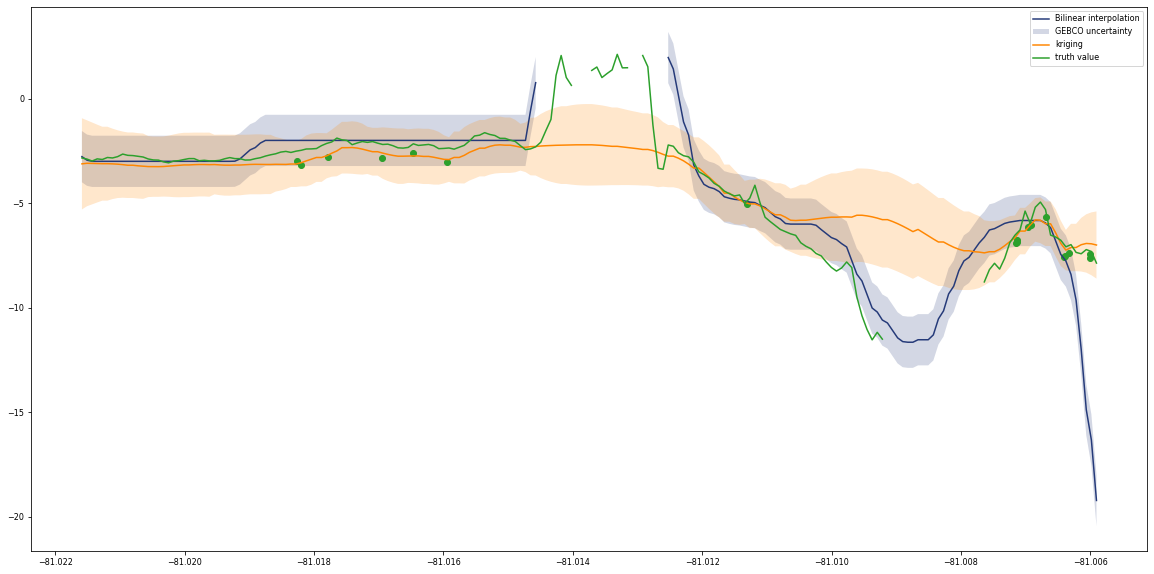

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(x, bilinear_gebco, label="Bilinear interpolation")
ax.fill_between(
    x,
    bilinear_gebco + np.sqrt(1.5),
    bilinear_gebco - np.sqrt(1.5),
    alpha=0.2,
    label="GEBCO uncertainty",
)
ax.plot(x, kriging, label="kriging")
ax.fill_between(
    x,
    kriging + np.sqrt(kriging_uncertainty),
    kriging - np.sqrt(kriging_uncertainty),
    alpha=0.2,
)
# ax.ca
ax.scatter(clipped_kriging_points.geometry.x, clipped_kriging_points.Z)
ax.plot(x, truth_values, label="truth value")
ax.legend()


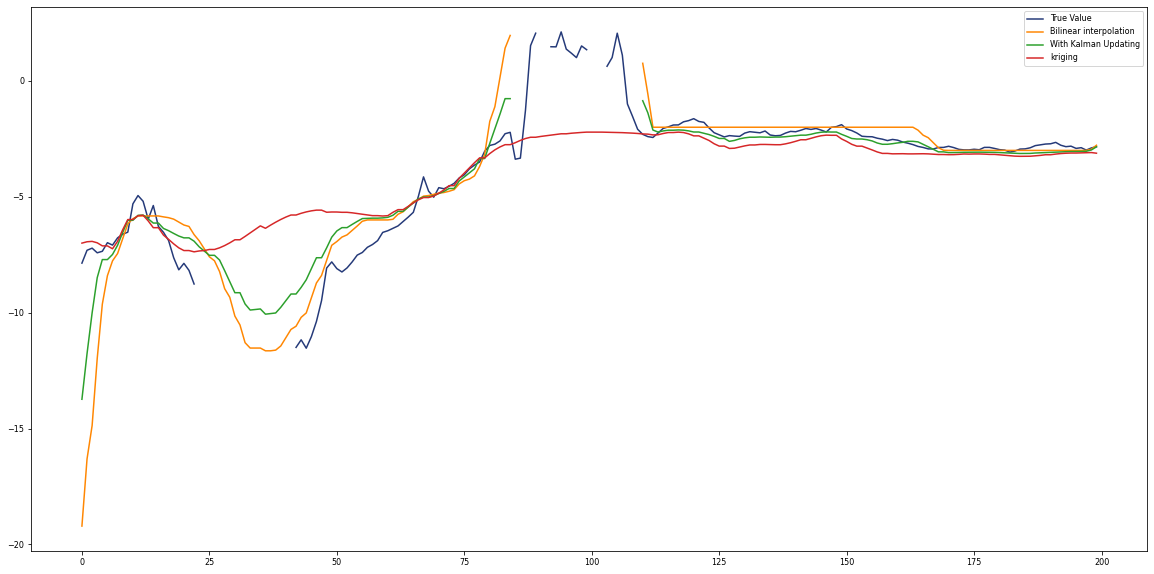

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(truth_values, label="True Value")
ax.plot(bilinear_gebco, label="Bilinear interpolation")
ax.plot(kalman, label="With Kalman Updating")
ax.plot(kriging, label="kriging")
ax.legend()
